This code is for analysis of the ColabFold-PDB complexes.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scienceplots


We want to find the ColabFold and experimental structures that most closely match for every protein in their active and autoinhibited states.

In [3]:

df = pd.read_csv('./project_pipeline/data/two-state_cf_pdb_compared.tsv', sep='\t').astype('object')
# df2 = pd.read_csv('./project_pipeline/data/classified_files_3.tsv', sep='\t').astype('object')

# df = df.drop(columns=['state', 'conformation'])

# df2 = df2[['uniprot', 'pdb', 'state', 'conformation', 'organism']]

# # Standardize the organism names
# df2['organism'] = df2['organism'].str.strip("").str.lower()

# df = df.merge(df2, how='left', on=['uniprot', 'pdb'])

df.head()

,uniprot,pdb,cluster,region_1,region_2,complex_rmsd,1.0_aligned,1.0_comp,1.1_aligned,1.1_comp,...,2.2_aligned,2.2_comp,2.3_aligned,2.3_comp,1_aligned,1_comp,2_aligned,2_comp,state,conformation
0,O08967,2r09,U10-005,"251-265,383-395",77-206,17.274,0.0,0.0,5.393,41.776,...,0.0,0.0,0,0,3.704,36.53,1.183,33.607,Autoinhibited,Closed
1,O08967,2r09,031,"251-265,383-395",77-206,19.503,0.0,0.0,4.997,33.114,...,0.0,0.0,0,0,3.394,36.86,3.58,31.059,Autoinhibited,Closed
2,O08967,2r09,U10-001,"251-265,383-395",77-206,16.866,0.0,0.0,4.727,19.795,...,0.0,0.0,0,0,3.276,24.538,1.148,23.513,Autoinhibited,Closed
3,O08967,2r09,U100-004,"251-265,383-395",77-206,21.285,0.0,0.0,5.3,38.422,...,0.0,0.0,0,0,3.414,51.587,1.331,52.734,Autoinhibited,Closed
4,O08967,2r09,029,"251-265,383-395",77-206,12.546,0.0,0.0,4.883,21.756,...,0.0,0.0,0,0,3.296,22.383,4.08,23.212,Autoinhibited,Closed


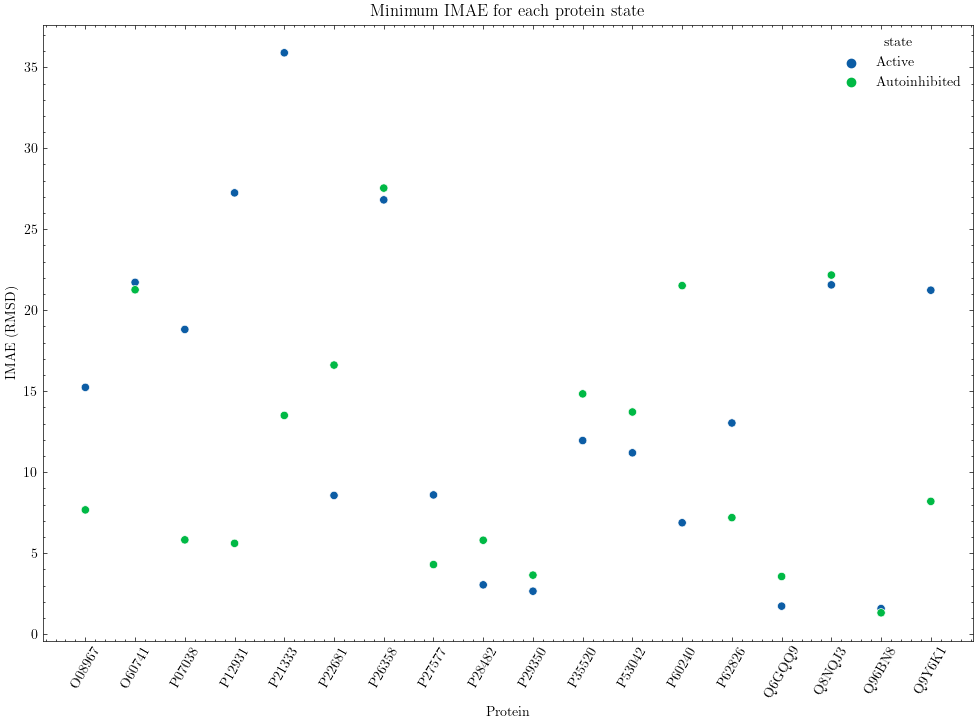

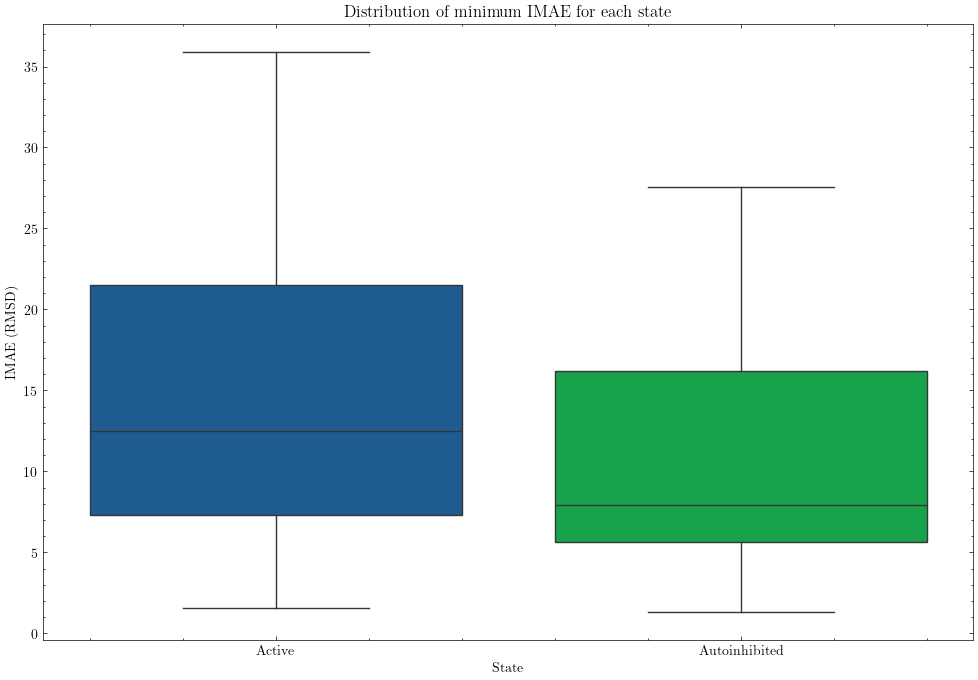

In [4]:
'''
With our dataframe corrected, we can now proceed with the analysis.
'''
plt.style.use('science')

# Drop state and conformation rows with missing values
df = df.dropna(subset=['state', 'conformation']).reset_index(drop=True)

# Convert columns to numeric
df['2_comp'] = pd.to_numeric(df['2_comp'], errors='coerce')

# Group by state and protein and find the minimum 2_comp for each group
df_min = df.groupby(['state', 'uniprot', 'pdb']).agg({'2_comp': 'min'}).reset_index()

df_clust = df[['uniprot', 'pdb', '2_comp', 'state', 'conformation', 'cluster']]

df3 = df_min.merge(df_clust, how='left', on=['uniprot', '2_comp', 'state', 'pdb']).drop_duplicates(subset=['uniprot', 'state'], keep='first').reset_index(drop=True)

# Plot the minimum 2_comp for each state
plt.figure(figsize=(12, 8))
sns.scatterplot(x='uniprot', y='2_comp', data=df3, hue='state')
plt.title('Minimum IMAE for each protein state')
plt.xlabel('Protein')
plt.ylabel('IMAE (RMSD)')
plt.xticks(rotation=60)

plt.savefig('./project_pipeline/data/figures/cf_pdb_closest_structures_per_state.png', format='png')

# Plot a boxplot of the distribution

fig, ax = plt.subplots(figsize=(12, 8))
sns.boxplot(x='state', y='2_comp', data=df3)
ax.set_title('Distribution of minimum IMAE for each state')
ax.set_xlabel('State')
ax.set_ylabel('IMAE (RMSD)')

plt.savefig('./project_pipeline/data/figures/cf_pdb_closest_structures_distribution.png', format='png')

# fig, ax = plt.subplots(figsize=(12, 8))
# sns.boxplot(x='organism', y='2_comp', data=df3)
# ax.set_title('Distribution of minimum IMAE for each organism')
# ax.set_xlabel('Organism')
# ax.set_ylabel('IMAE (RMSD)')
# for tick in ax.get_xticklabels():
#     tick.set_rotation(60)
# plt.savefig('./project_pipeline/data/figures/cf_pdb_closest_structures_distribution_organism.png', format='png')


# medians = df3.groupby('organism')['2_comp'].median().values
# print(medians)
# nobs = df3['organism'].value_counts().values
# print(nobs)
# nobs = [str(x) for x in nobs.tolist()]
# nobs = ['n: ' + i for i in nobs]

# pos = range(len(nobs))
# for tick, label in zip(pos,ax.get_xticklabels()):
#     ax.text(pos[tick],
#             medians[tick] + 0.03,
#             nobs[tick],
#             horizontalalignment='center',
#             size='small',
#             color='black',
#             weight='semibold')

Now let's look at all ColabFold-to-PDB structure comparison.

Autoinhibited    42567
Active           13652
Name: state, dtype: int64
U10-005     278
U10-009     278
U100-002    278
U10-003     278
U10-007     278
           ... 
239         117
251         117
277         117
279         117
240         117
Name: cluster, Length: 332, dtype: int64


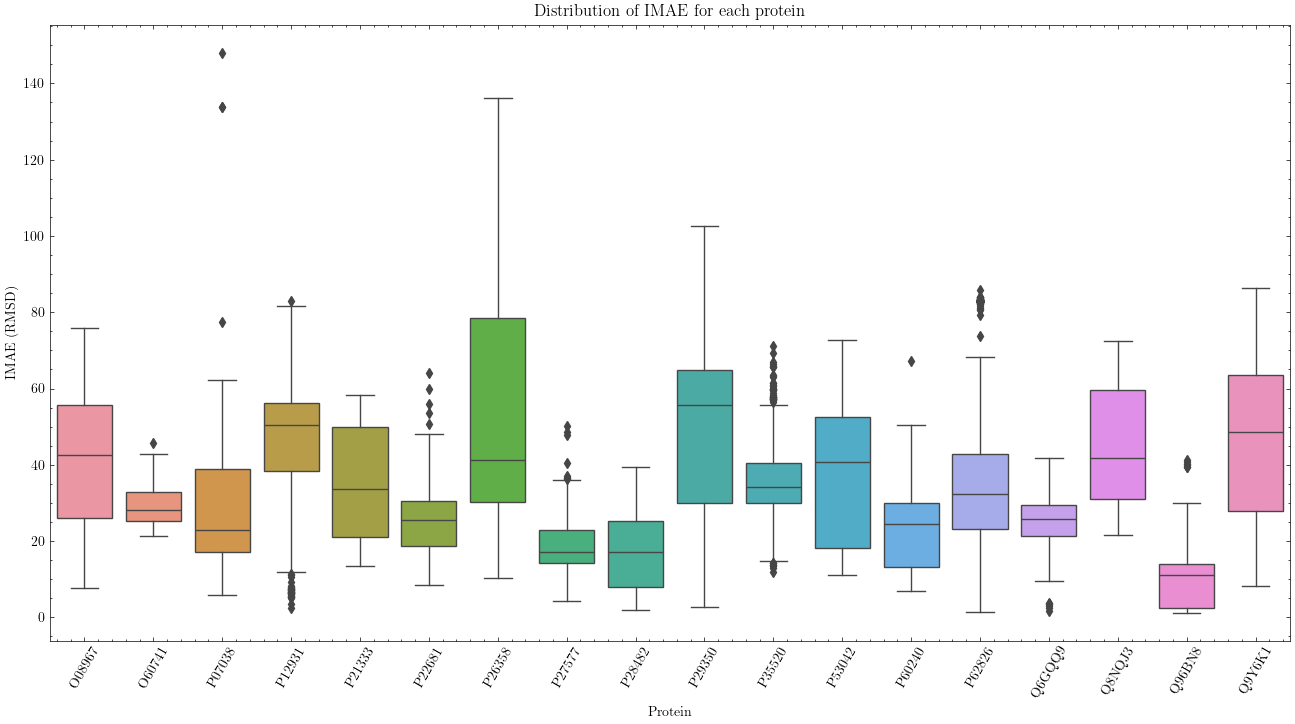

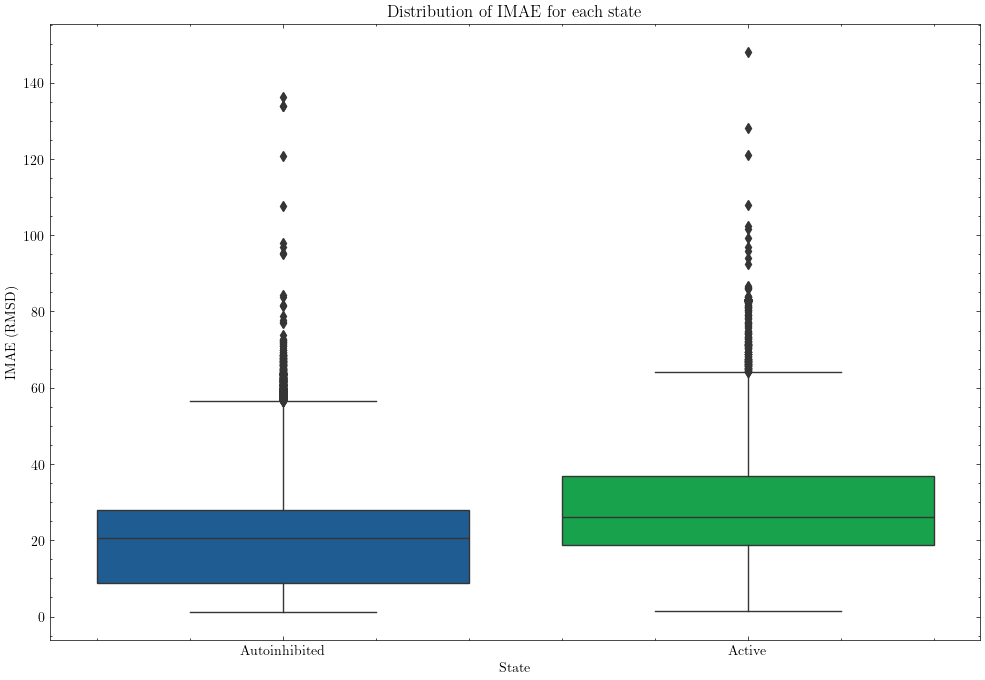

In [8]:
# Plot the distribution of minimum IMAE for each protein
fig, ax = plt.subplots(figsize=(16, 8))
sns.boxplot(x='uniprot', y='2_comp', data=df)
ax.set_title('Distribution of IMAE for each protein')
ax.set_xlabel('Protein')
ax.set_ylabel('IMAE (RMSD)')
for tick in ax.get_xticklabels():
    tick.set_rotation(60)

plt.savefig('./project_pipeline/data/figures/cf_pdb_distribution_protein_all.png', format='png')

# Now plot the distribution of minimum IMAE for each state
fig, ax1 = plt.subplots(figsize=(12, 8))
sns.boxplot(x='state', y='2_comp', data=df, ax=ax1)
ax1.set_title('Distribution of IMAE for each state')
ax1.set_xlabel('State')
ax1.set_ylabel('IMAE (RMSD)')

# dfg = df.groupby('state')

# counts = [len(v) for k, v in dfg]
# total = float(sum(counts))
# cases = len(counts)

# widths = [c/total for c in counts]

# ax1.set_xticklabels(['%s\n$n$=%d'%(k, len(v)) for k, v in dfg])

plt.savefig('./project_pipeline/data/figures/cf_pdb_distribution_state_all.png', format='png')


# What are the counts of each?
up_count = df['uniprot'].value_counts()
state_count = df['state'].value_counts()
cluster_count = df['cluster'].value_counts()
print(state_count)
print(cluster_count)

What does the cluster performance look like for the closest-fitting structures?

U100-004    4
U10-007     3
U10-003     3
U100-009    3
U100-001    2
U100-007    2
U100-002    2
U10-009     2
U10-004     2
U100-008    2
137         1
001         1
005         1
010         1
U100-005    1
U100-006    1
025         1
U10-005     1
U100-003    1
105         1
076         1
Name: cluster, dtype: int64


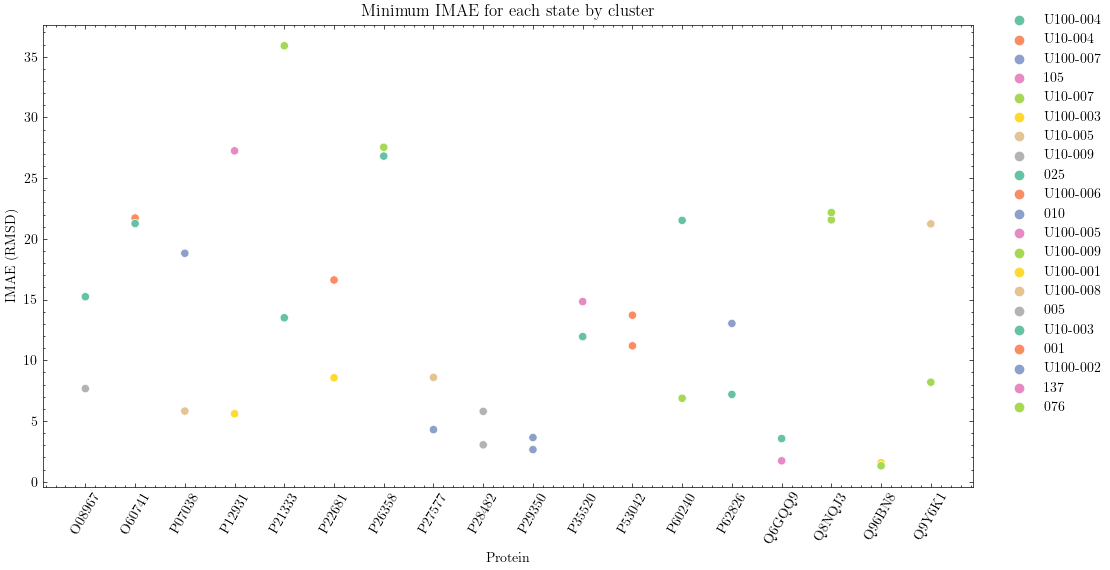

In [9]:
# Show a scatterplot by cluster
plt.style.use('science')

fig, ax = plt.subplots(1, 1, figsize=(12, 6))
sns.scatterplot(x='uniprot', y='2_comp', data=df3, hue='cluster', palette='Set2')
ax.set_title('Minimum IMAE for each state by cluster')
ax.set_xlabel('Protein')
ax.set_ylabel('IMAE (RMSD)')
ax.legend(bbox_to_anchor=(1.15, 1.05))
for tick in ax.get_xticklabels():
    tick.set_rotation(60)

plt.savefig('./project_pipeline/data/figures/cf_pdb_closest_structures_distribution_cluster.png', format='png')

# medians = df3.groupby('cluster')['2_comp'].median().values
# nobs = df3['cluster'].value_counts().values
# nobs = [str(x) for x in nobs.tolist()]
# nobs = ['n: ' + i for i in nobs]

# pos = range(len(nobs))
# for tick, label in zip(pos,ax[1].get_xticklabels()):
#     ax[1].text(pos[tick],
#             medians[tick] + 0.03,
#             nobs[tick],
#             horizontalalignment='center',
#             size='small',
#             color='black',
#             weight='semibold')

cluster = df3['cluster'].value_counts()
print(cluster)